# Introduction to Machine Learning and scikit-learn
We've learned how to load EEG and task events, extract spectral power, and run univariate statistics to correlate spectral power with episodic memory. But there's also a way to correlate memory with *entire patterns* of neural time series across frequency bands and electrodes. We generally call these "multivariate" methods, but these approaches are more commonly known as **machine learning** (ML).

Don't be intimidated if you've never used machine learning algorithms before. They are often pretty intuitive, and machine learning software packages are mature. It only takes a few lines of code to start using powerful machine learning algorithms. 

**The Big Picture**: The big idea of machine learning is to discover patterns in data. In many ways, machine learning is just a more flexible way of doing statistics, in that it lets us interpret data as it relates to a real-world variable of interest. Most things called "machine learning" take observations of data (called **features**) and use them to make predictions about a variable of interest. In doing so, machine learning models find values for weights, or **parameters**, that can also be useful to data scientists. 

For example, in the recent content we covered how to correlate power at specific frequencies and channels with subsequent memory. These univariate methods effectively allow us to predict whether a subject will later recall an item on the basis of each individual feature (power at a given frequency and channel) separately. ML algorithms let us use those same data to make stronger predictions about whether an item will be remembered by incorporating information from all features. 

## Linear Regression
Linear regression is the "simplest" kind of machine learning! Note that much of this lesson on linear regression and its text was originally sourced from: https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html

In [1]:
import numpy as np
import pandas as pd
import cmlreaders as cml
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold
from scipy.stats import ttest_ind

In [2]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In machine learning, we call these tables **"feature matrices."** The *target array*, or set of values we'd like to predict, is often just called "y." For example, if we wanted to predict flower species from flower morphology, the species name would be the y vector.

<img src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.02-samples-features.png">

In [3]:
#Construct a feature matrix without the species
X_iris = iris.drop('species', axis=1)

#Construct the y vector
Y_iris = iris['species']

print(X_iris.shape)
print(Y_iris.shape)

(150, 4)
(150,)


### Performing linear regression
1. **Choose a class of model**

In Scikit-Learn, every class of model is represented by a Python class. So, for example, if we would like to compute a simple linear regression model, we can import the linear regression class (which we did above).

2. **Choose model hyperparameters**

An important point is that a class of model is not the same as an *instance* of a model.

Once we have decided on our model class, there are still some options open to us. Depending on the model class we are working with, we might need to answer one or more questions like the following:

* Would we like to fit for the offset (i.e., y-intercept)?
* Would we like the model to be normalized?
* Would we like to preprocess our features to add model flexibility?
* What degree of regularization would we like to use in our model? 
    * Regularization "smooths" model predictions to prevent "overfitting" to spurious noise patterns.
* How many model components would we like to use?

These are examples of the important choices that must be made once the model class is selected. These choices are often represented as hyperparameters, or parameters that must be set before the model is fit to data. In Scikit-Learn, hyperparameters are chosen by passing values at model instantiation.

In [4]:
# we're setting the fit_intercept hyperparameter
model = LinearRegression(fit_intercept=True)
model

LinearRegression()

3. **Arrange data into feature matrix and target vector.**

(50, 1)


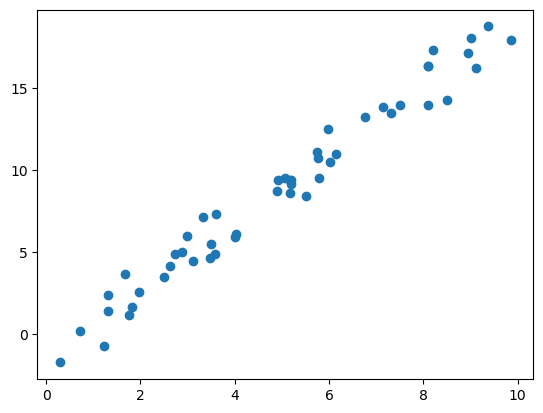

In [5]:
#Here, we're going to use synthesized data. Give some random data a slope of 2 and an intercept of -1, and add a bit of noise
np.random.seed(102)  # comment this out to get different results on each run. Leave uncommented for consistent results (useful for debugging)

N = 50
x = 10 * np.random.rand(N)
y = 2 * x - 1 + np.random.randn(N)
plt.scatter(x, y);

#Technically, X needs to be an nx1 shaped array, so...
X = x[:, np.newaxis]
print(X.shape)

4. **Fit the model!**

In [6]:
model.fit(X, y)

LinearRegression()

In [7]:
# Inspect the model parameters
print(model.coef_)
print(model.intercept_)

[2.07570181]
-1.4630352912248448


The model found something pretty close to our original parameters!

5. **Predict labels on unknown data**

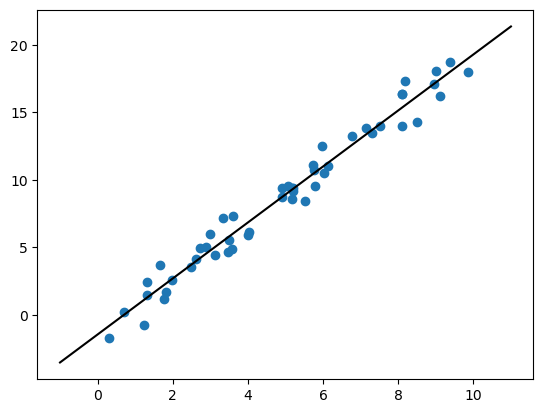

In [8]:
# Plot learned linear relationship
xfit = np.linspace(-1, 11)
Xfit = xfit[:, np.newaxis]
yfit = model.predict(Xfit)

plt.scatter(x, y)
plt.plot(xfit, yfit, 'k');

An additional informative parameter, R^2, the coefficient of determination, can be defined as "the proportion of the variation in the dependent variable that is predictable from the independent variable(s)".

In [9]:
#Return the R^2 prediction score
print('R^2: '+str(model.score(X, y)))

#Calculate manually
y_pred = model.predict(X)
# 1 minus the sum of squares of the "residuals" over the
# "total sum of squares" that would go into a variance calculation.
r2_manual = 1-np.sum((y_pred-y)**2)/np.sum((np.mean(y)-y)**2)

print('R^2 manual: '+str(r2_manual))

#And another way
from scipy.stats import pearsonr
r, p = pearsonr(y_pred, y)
print('r**2: '+str(r**2))

R^2: 0.9700259025262968
R^2 manual: 0.9700259025262968
r**2: 0.9700259025262974


**Exercise: Make a modification of the above to generate random data, a plot, and calculating R^2, and try a few values to figure out what amplitude of noise you need to add to get an R^2 of 0.5.  Then examine what the plot data looks like at this value.**

**Exercise: Now take the same data that gave you R^2 of about 0.5, and add a single additional outlier point with x=200, y=200.  Then make the same plot and calculate R^2.**

## Logistic Regression
Linear regression allows us to predict a continuous outcome $y$ (with normally distributed errors) from a set of features $x$. However many estimation problems, known as classification problems, involve predicting discrete outcomes (e.g. 'pass' vs. 'fail' or 'recalled' vs. 'not') rather than continuous ones. Logistic regression is a classification method that estimates the probability $p$ that an observation belongs to one of two discrete classes from the observed features $x$. Here we will use logistic regression to predict whether subjects will recall an item during a free recall task based on EEG features recorded when the item was presented. In logistic regression, we model the probability of a binary event occurring by mapping a weighted sum of features to a value ranging from 0 to 1 with the logistic function or sigmoid shown here for the "logistic model" for a single feature $x$:

<img src="https://www.saedsayad.com/images/LogReg_1.png">

A trained classification model or classifier will typically output a continuous "score" that quantifies how confident the classifier is that an observation belongs to a given class. A predictive threshold is then set to maximize some classification performance metric. In the case of logistic regression, the predictive "score" is the predicted probability $p$, and the threshold is commonly set to 0.5: simply predict a label of '1' if the predicted probability is greater than 0.5 (more likely than not) and '0' otherwise. The threshold more generally is selected in part based on the relative proportions of the two classes in the training data (i.e., if there are far more "passes" than "fails" in the data, the classifier will tend to predict "passes" and require more evidence to predict "fail").

Let's look at an example: classification of breast cancer status.

In [10]:
# load data of observations of health indicators with outcomes of
# whether or not a tumor is malignant.
X, y = load_breast_cancer(return_X_y=True)

In [11]:
X.shape

(569, 30)

In [12]:
y.shape

(569,)

In [13]:
X

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])

In [14]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

### Preparing the feature matrix

Typically, a feature matrix is a 2D array, with observations as rows and features as columns. You can have as many observations and features as available, but keep in mind that too many features relative to the number of observations can cause issues down the road. If you have many observations and only a handful of features, that should not be a problem. 

It's often good practice to have features standardized/normalized. This ensures features will tend to fall in similar ranges of values, making them more comparable.  One way to do this is by z-scoring.

Text(0, 0.5, 'Observations')

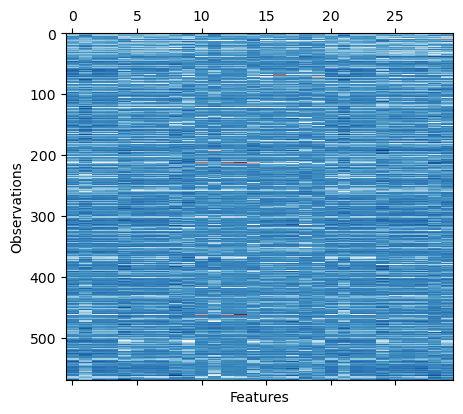

In [15]:
# z-score features to make them comparable and visualize
X = (X - X.mean(axis=0)) / X.std(axis=0, ddof=1)

plt.figure(figsize=(5, 4.5))
ax = plt.subplot(111)
plt.matshow(X, aspect='auto', cmap='RdBu_r', 
            vmin=np.min(X), vmax=np.max(X), 
            fignum=0)
plt.xlabel('Features')
plt.ylabel('Observations')

### Fitting a model on training data: Hyperparameters

Solely for instructional purposes, we're going to do something bad: We're going to train a logistic regression model and test it on the same data. In a real-world machine learning setting, you would almost never do this, because the model will be **overfit** to the training data. That is, it will show a much higher performance than it would in real-world tests on held-out datasets (datasets which were not trained on).

Key things to know about fitting a logistic regression model: 

* **Penalty parameter**: The degree to which the model discounts the contribution of each observation, as a first line of defense against overfitting. This is usually called 'C' in sckikit-learn functions. 
* **Regularization method**: The manner in which weights are discounted, called 'penalty' in sckikit-learn. For many purposes in the lab, you may want to use the 'l2' norm, which means that weights are penalized according to their squared magnitude. In other words, the larger the coefficient, the more it will be penalized.

In [16]:
# How to fit a logistic regression model using scikit-learn.
# Parameter "class_weight" helps to adjust for the fact that the number of
# elements in the two conditions (e.g. remembered and not-remembered items)
# are very unequal or imbalanced.
lr_classifier = LogisticRegression(C=100, penalty='l2', class_weight='balanced',
                                   solver='liblinear')
lr_classifier.fit(X, y)

LogisticRegression(C=100, class_weight='balanced', solver='liblinear')

### Computing an AUC and plotting ROC curves

How do we assess how well our classifier is doing? We could simply ask for percent correct -- what proportion of the total items did the classifier guess correctly? The problem with this approach is that it does not account for the different *ways* in which a classifier can be correct or incorrect. For instance, if there are far more samples with one class label than another, the classifier could simply always predict the more common label and achieve a high accuracy while learning little about the underlying data. What we really want to know is, how well does our classifier *distinguish* between two groups on the basis of the observed features?

The solution is to measure the **area under the receiver operating characteristic curve**. Let's unpack what this means! 

A classifier has: 

* A True Positive Rate (TPR): The rate at which the classifier says "1" when the truth is "1." Also called **sensitivity**.
* A False Positive Rate (FPR): The rate at which the classifier says "1" when the truth is "0." This is captured by 1-**specificity**. 

<br>
<center>
<img src="https://acutecaretesting.org/-/media/acutecaretesting/articles/table-i-comparing-a-method-with-the-clinical-truth.gif?w=300&h=193&as=1&la=en">
</center>
<br>

Ideally, a classifier can fully separate true and false data. That is, it won't say "1" when the truth is a zero, but will say "1" when the truth is a "1". Note that a classifier could correctly identifiy every single "1", but if it's also saying "1" in response to a bunch of zeros, it isn't a very useful classifier! That is, **we want classifiers with high sensitivity (true positives) but also low 1-specificity (false positives).** The ROC is a way of measuring such performance, by **explicitly graphing the tradeoff between sensitivity and specificity at various thresholds.**

<br>
<center>
<table>
    <tr>
        <th><img src="https://cdn-images-1.medium.com/max/1600/1*yF8hvKR9eNfqqej2JnVKzg.png"></th>
        <th><img src="https://cdn-images-1.medium.com/max/800/1*-tPXUvvNIZDbqXP0qqYNuQ.png" width=250></th>
    </tr>
</table>
</center>

As you sweep the threshold across the two distributions, the TPR and FPR are measured at each point, and plotted against each other on 2D axes. After sweeping through the entire range, you're left with an ROC curve -- each point at the end must exist at [0, 0] and [1, 1], because we are either completely guessing "True" or completely  guessing "False." The shape of the curve in the middle tells you how good the classifier is.

The **AUC** is a single number that quantifies the curve's shape. If the AUC is 0.5, that means it lies flat along the diagonal, and our two distributions are overlapping; TPR and FPR are the same at every threshold. If the AUC is 1, that means our two distributions are completely non-overlapping, and a single threshold can perfectly distinguish between them with no errors. (An AUC of zero would mean the classifier is able to distinguish the two classes, but is flipping the label!)

In [17]:
#scikit-learn makes it very easy to get AUCs and ROCs
prob_array = lr_classifier.predict_proba(X)[:,1]
auc = roc_auc_score(y, prob_array)
print(auc)

0.9992732942233498


Text(0.5, 1.0, 'Training Data ROC-curve')

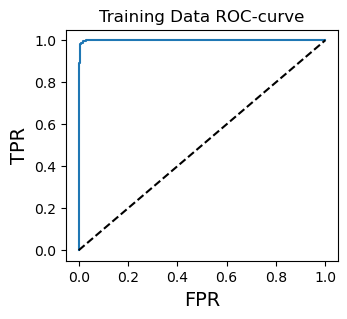

In [18]:
roc_curve_data_train = roc_curve(y, prob_array)
fpr_train = roc_curve_data_train[0]  #false positive rate
tpr_train = roc_curve_data_train[1]  #true positive rate

#Plot results
plt.figure(figsize=(3.5, 3))
ax = plt.subplot(111)
plt.plot(fpr_train, tpr_train)
plt.plot((0.0,1.0),(0.,1.),'k--')
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.title('Training Data ROC-curve')

**Exercise: Assess the robustness to noise of logistic regression classification by taking the breast cancer data example dataset provided by sklearn, and adding positive and negative balanced random noise from amplitude +/-0 through +/-30.  Prepare a plot with the noise amplitude added on the x axis, and the AUC obtained on the y axis.**